### Pinecone Dense and Sparse Vector - Improved Chunking through pages with previous cleaning with LLM

In [1]:
import os
from database_manager import MySQLDB,PineconeDBConnectorHybrid
from chunking_embeding_docs import config as db_config,db_name
from dotenv import load_dotenv

load_dotenv()

API_PINE_CONE = os.getenv('API_PINE_CONE')

root_dir = '/Users/rodolfocacacho/Documents/Documents/MAI/Master Thesis/Code/rag_clean_v2'
original_dir = os.getcwd()
os.chdir(root_dir)

metadata_csv = 'data/documents/metadata/Files_date_version.csv'
output_dir = 'data/storage/tables'

# SQL Tables
table_documents_name = 'table_documents'

max_tokens = 250
suffix = 'clean'
sql_chunks_table = f'chunks_table_{suffix}_{max_tokens}'
sql_table_vocab = f'vocabulary_bm25_{suffix}_{max_tokens}'

embed_model = "jinaai/jina-embeddings-v2-base-de"
embed_model_name = embed_model.split("/")[1]
model_dimension = 768

index_name = f'{embed_model_name}-{suffix}-{max_tokens}'

sql_con = MySQLDB(config=db_config,database_name=db_name)
vec_con = PineconeDBConnectorHybrid(api_key=API_PINE_CONE,
                                    index_name=index_name,
                                    embedding_model_name_dense=embed_model,
                                    dimension=model_dimension)

/Users/rodolfocacacho/miniforge3/envs/rag_unstructured/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rodolfocacacho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Embedding Dimension: 768
Using existing Pinecone index: jina-embeddings-v2-base-de-clean-250


### Chunking

In [2]:
os.chdir(original_dir)
from chunking_embeding_docs import semantic_chunking
os.chdir(root_dir)

total_upserted = semantic_chunking(sql_con = sql_con,
                                   table_documents_name = table_documents_name,
                                   table_chunks_name = sql_chunks_table,
                                   df_code_path = metadata_csv,
                                   max_tokens =max_tokens,
                                   output_dir = output_dir)

print(f"{total_upserted} chunks were upserted to {sql_chunks_table}")



Documents: 79
Document Richtlinie BEG EM (2020-12-17).pdf : Pages 40 : Chunks 127
Document Richtlinie BEG EM (2023-12-21).pdf : Pages 38 : Chunks 133
Document Richtlinie BEG EM (2022-07-21)_Änderung.pdf : Pages 2 : Chunks 6
Document Richtlinie BEG EM (2021-05-20).pdf : Pages 45 : Chunks 144
Document Richtlinie BEG EM (2021-09-16).pdf : Pages 42 : Chunks 143
Document Richtlinie BEG EM (2022-12-09).pdf : Pages 41 : Chunks 129
Document Richtlinie BEG EM (2022-09-15)_Änderung.pdf : Pages 1 : Chunks 2
Document Allgemeines Merkblatt zur Antragstellung - Zuschuss_1.9 (2024-01-01).pdf : Pages 16 : Chunks 25
Document Allgemeines Merkblatt zur Antragstellung - Zuschuss_1.10 (2024-04-01).pdf : Pages 16 : Chunks 25
Document Allgemeines Merkblatt zur Antragstellung - Zuschuss_1.6 (2023-01-01).pdf : Pages 14 : Chunks 22
Document Allgemeines Merkblatt zur Antragstellung - Zuschuss_1.8 (2023-08-31).pdf : Pages 14 : Chunks 21
Document Allgemeines Merkblatt zur Antragstellung - Zuschuss_1.7 (2023-01-0

### BM25 Vector creation and Obtain vectors to embed

In [2]:
os.chdir(original_dir)
from chunking_embeding_docs import embedding_bm25_calculation
os.chdir(root_dir)


upsert_list = embedding_bm25_calculation(sql_con=sql_con,
                                        table_name=sql_chunks_table,
                                        table_store=sql_table_vocab)

Data retrieved from database table 'chunks_table_clean_250'.


### Upsert created vectors

In [4]:
# Embedding handler (use either API or transformer model)
os.chdir(original_dir)
from embedding_handler import EmbeddingHandler
from chunking_embeding_docs import process_and_upload
os.chdir(root_dir)


embedding_handler = EmbeddingHandler(
    model_name="jinaai/jina-embeddings-v2-base-de",  # Replace with your transformer model
    use_api=False,  # Set to True if using API
)


process_and_upload(chunks=upsert_list,
                   pinecone_connector=vec_con,
                   embedding_handler=embedding_handler,
                   use_sparse=True
                   )


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1
Uploaded batch 1/1
All batches uploaded successfully.


In [3]:
for i in upsert_list:
    for key,vals in i.items():
        print(f"{key} {vals} {type(vals)}")

id 1.0 <class 'str'>
content Bundesministerium für Wirtschaft und Energie
Richtlinie für die Bundesförderung für effiziente Gebäude
- Einzelmaßnahmen (BEG EM)
Vom 17. Dezember 2020
1 Präambel
Mit der Energiewende hat die Bundesrepublik Deutschland eine umfassende und tiefgreifende Transformation ihrer Energieversorgung und Energienutzung eingeleitet. Die Bundesregierung hat sich das Ziel gesetzt, bis 2030 die Treibhausgasemissionen um mindestens 55 Prozent gegenüber dem Basisjahr 1990 zu mindern. Für 2030 gilt, dass der Gebäudebereich nach dem Klimaschutzgesetz (gemäß Quellprinzip) nur noch 70 Millionen Tonnen CO2-Äquivalente emittieren darf. Darüber hinaus hat sich Deutschland das Ziel gesetzt, beim Endenergieverbrauch im Wärme- und Kältesektor, der zu circa zweidrittel aus dem Gebäudebereich besteht, einen Anteil erneuerbarer Energien am Endenergieverbrauch für Wärme und Kälte von 27 Prozent (in 2018: 14,2 Prozent) zu erreichen. Dies wird die Bundesregierung auch in ihrem integrierte

In [3]:
upsert_list

[{'id': '1.0',
  'content': 'Bundesministerium für Wirtschaft und Energie\nRichtlinie für die Bundesförderung für effiziente Gebäude\n- Einzelmaßnahmen (BEG EM)\nVom 17. Dezember 2020\n1 Präambel\nMit der Energiewende hat die Bundesrepublik Deutschland eine umfassende und tiefgreifende Transformation ihrer Energieversorgung und Energienutzung eingeleitet. Die Bundesregierung hat sich das Ziel gesetzt, bis 2030 die Treibhausgasemissionen um mindestens 55 Prozent gegenüber dem Basisjahr 1990 zu mindern. Für 2030 gilt, dass der Gebäudebereich nach dem Klimaschutzgesetz (gemäß Quellprinzip) nur noch 70 Millionen Tonnen CO2-Äquivalente emittieren darf. Darüber hinaus hat sich Deutschland das Ziel gesetzt, beim Endenergieverbrauch im Wärme- und Kältesektor, der zu circa zweidrittel aus dem Gebäudebereich besteht, einen Anteil erneuerbarer Energien am Endenergieverbrauch für Wärme und Kälte von 27 Prozent (in 2018: 14,2 Prozent) zu erreichen. Dies wird die Bundesregierung auch in ihrem integr

### Graph analysis

In [5]:
from collections import Counter

class WordFrequencyAnalyzer:
    def __init__(self):
        # Initialize an empty Counter to store word frequencies
        self.word_frequencies = Counter()

    def update_words(self, words):
        """
        Updates the word frequency counter with a new list of words.
        
        Args:
            words (list): List of words to add/update in the frequency count.
        """
        self.word_frequencies.update(words)

    def get_top_words(self, n=10):
        """
        Returns the top n most frequent words, ordered by frequency.
        
        Args:
            n (int): Number of top frequent words to return.
        
        Returns:
            list: List of tuples (word, frequency).
        """
        return self.word_frequencies.most_common(n)

    def word_character_count(self):
        """
        Returns a dictionary with words as keys and their character counts as values.
        
        Returns:
            dict: Dictionary with word character counts.
        """
        return {word: len(word) for word in self.word_frequencies.keys()}


In [6]:
# print_terms = 10
# printed = 0
vocabulary_set = set()
voc_analyzer = WordFrequencyAnalyzer()

for irecord,record in enumerate(records):
    id = record['id']
    content = record['content']
    clean_content = record['clean_content']
    extracted_vals = record['extracted_values']
    metadata = json.loads(record['metadata'])
    type = metadata['doc_type']
    tokens = record['bm25_tokens']
    vocabulary_set.update(tokens)
    voc_analyzer.update_words(tokens)
    # if 'wasser-wärmepumpenmodellvariationenhks' in tokens:
    #     print(f'{id}:\n\nOriginal:\n{content}\n\nClean:\n{clean_content}\n\nTokens: {tokens}\n\nExtracted: {extracted_vals}\n')
        

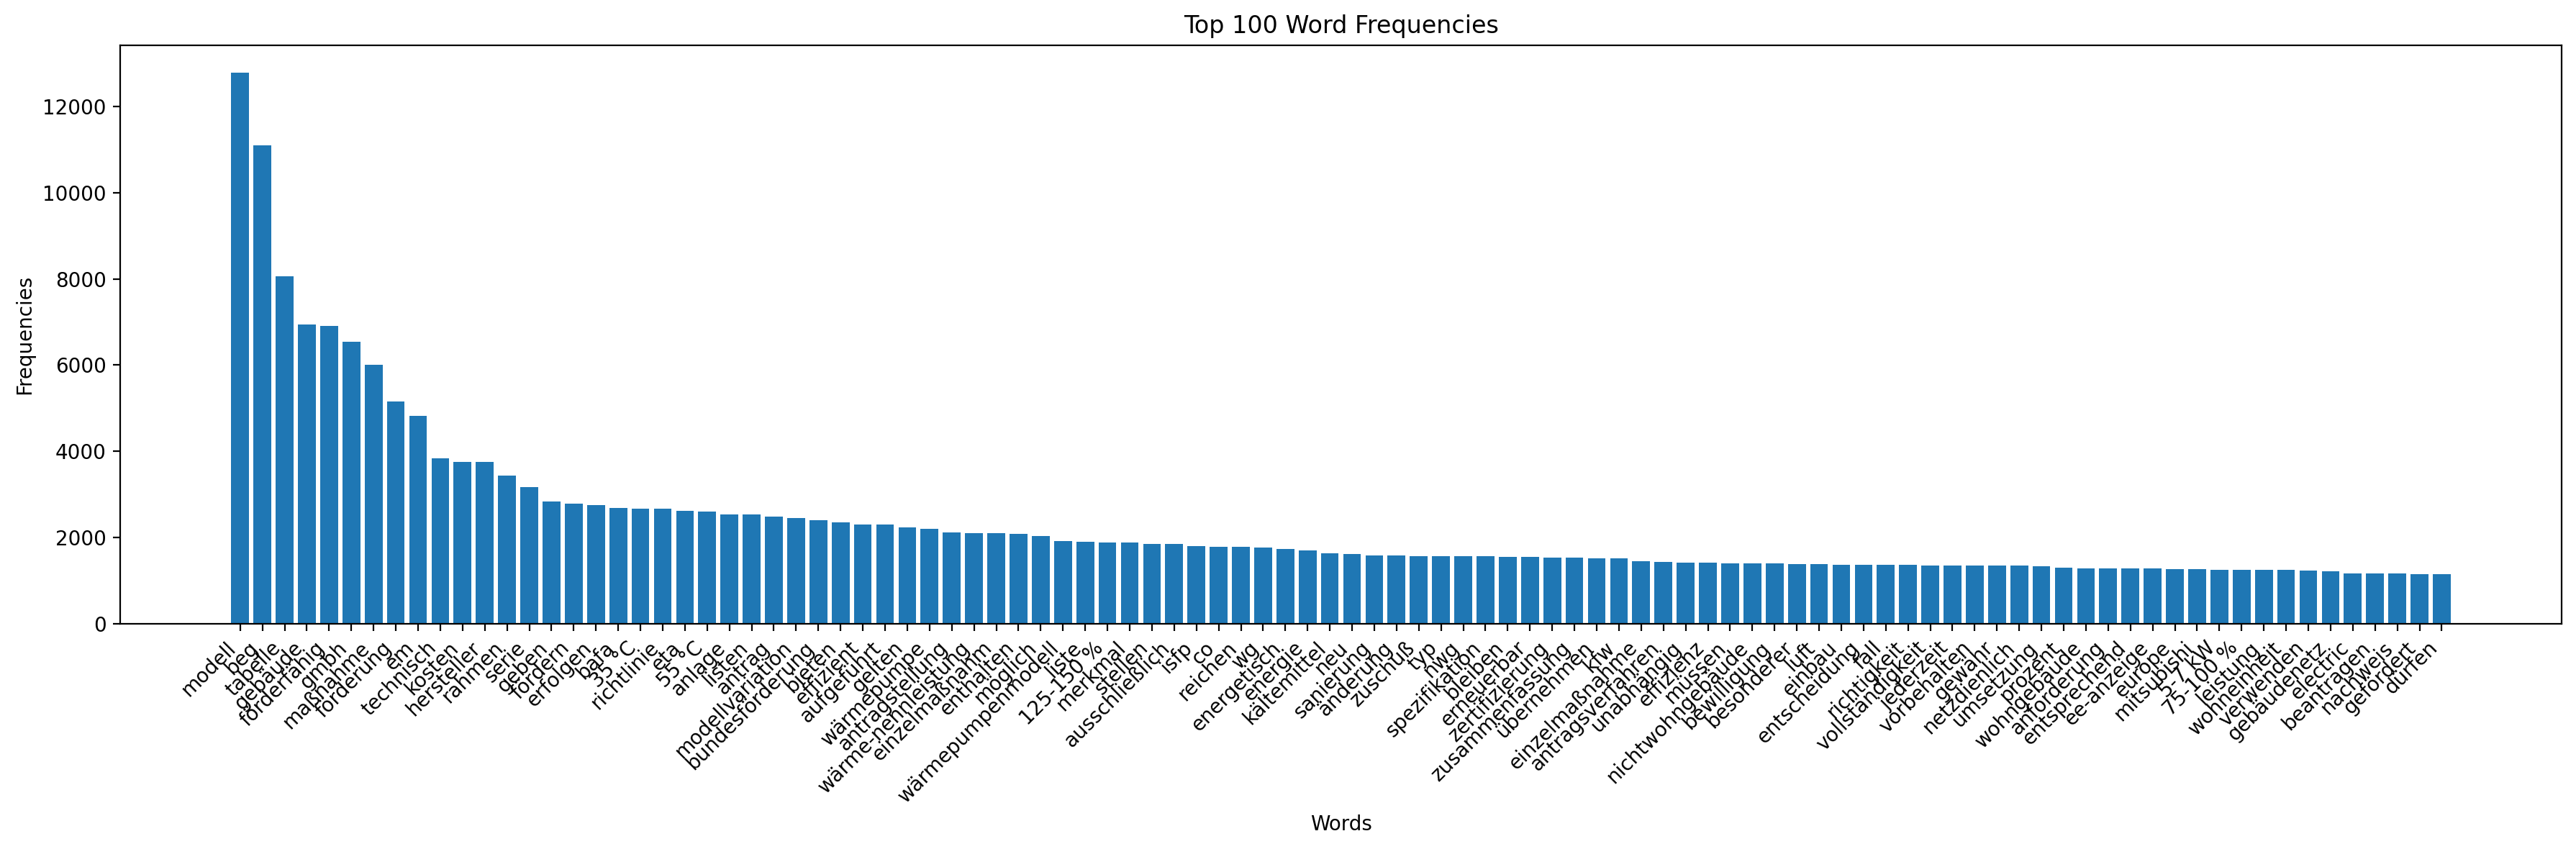

In [10]:
import matplotlib.pyplot as plt

def plot_word_frequencies(top_words, title="Word Frequencies"):
    """
    Plots a bar chart for the top words and their frequencies.

    Args:
        top_words (list): List of tuples (word, frequency).
        title (str): Title of the plot.
    """
    words = [word for word, freq in top_words]
    frequencies = [freq for word, freq in top_words]
    
    plt.figure(figsize=(18, 6),dpi=200)
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequencies')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
top_words = voc_analyzer.get_top_words(100)  # Get top 20 words
plot_word_frequencies(top_words, title="Top 100 Word Frequencies")

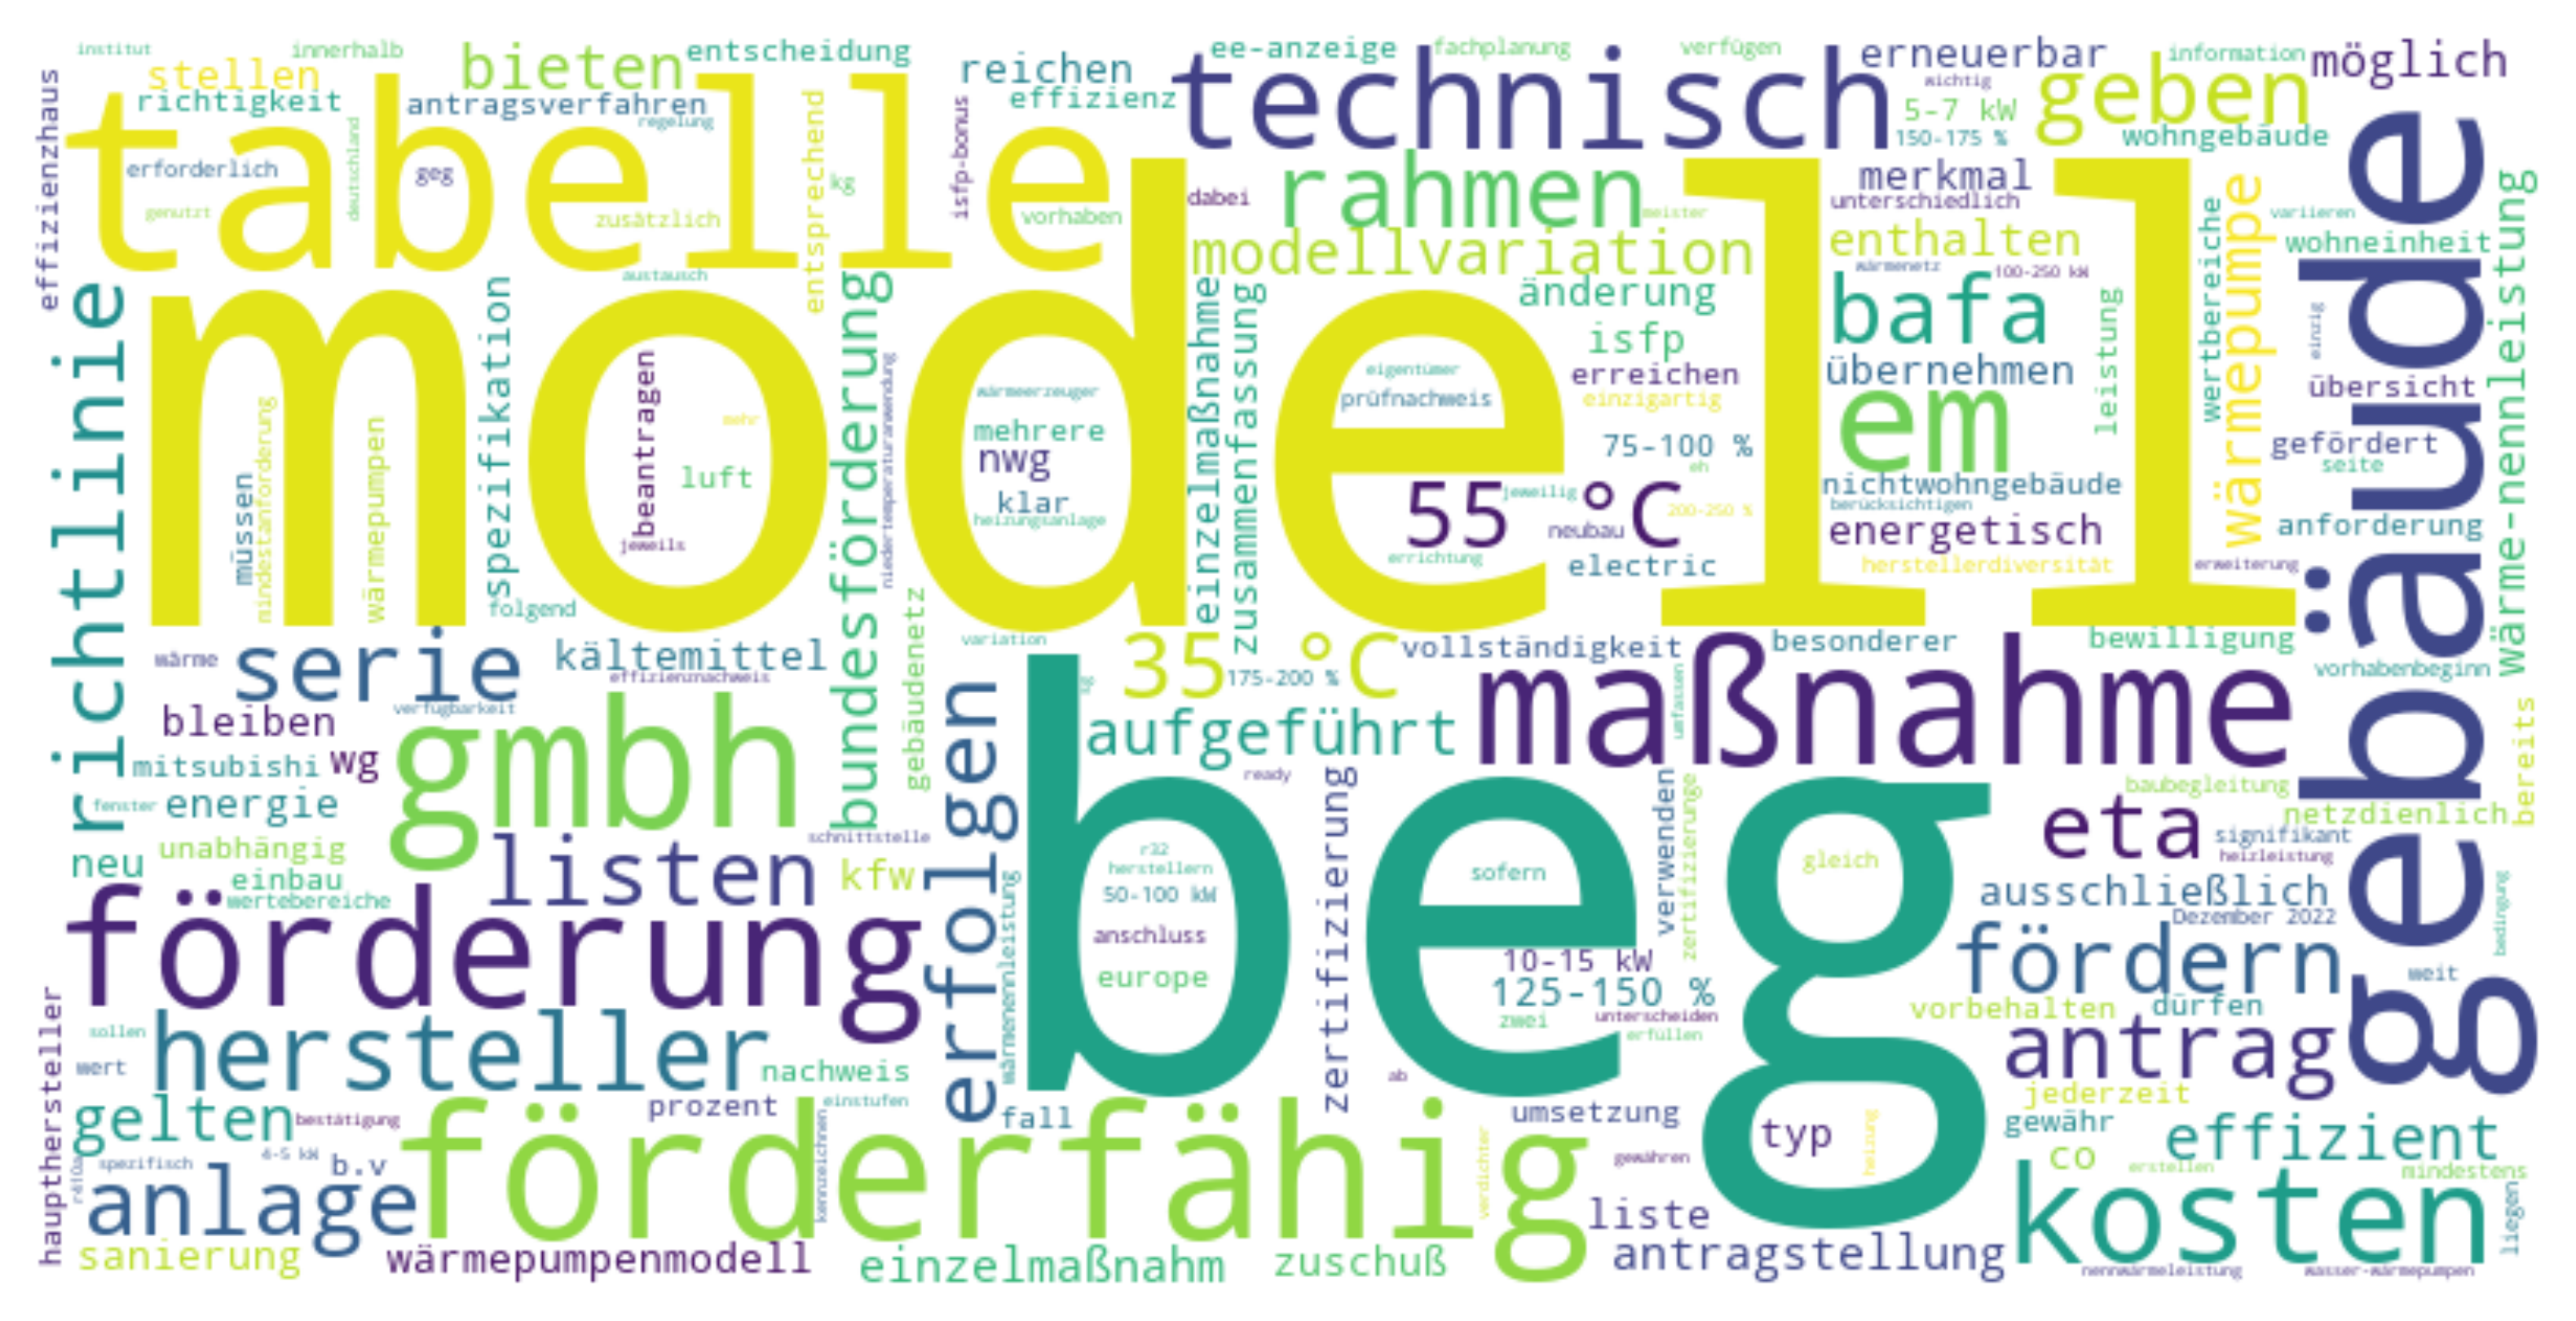

In [11]:
from wordcloud import WordCloud

def plot_word_cloud(word_frequencies):
    """
    Generates and displays a word cloud from word frequencies.

    Args:
        word_frequencies (dict): Dictionary of word frequencies.
    """
    wordcloud = WordCloud(width=800, height=400, background_color="white",min_word_length=3).generate_from_frequencies(word_frequencies)
    
    plt.figure(figsize=(10, 5),dpi = 400)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Example usage:
word_frequencies = dict(voc_analyzer.word_frequencies)  # Convert Counter to dict
plot_word_cloud(word_frequencies)

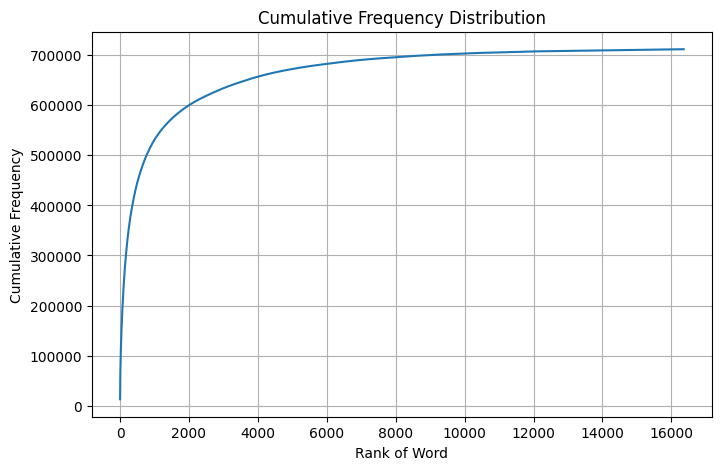

In [45]:
def plot_cumulative_frequencies(word_frequencies):
    """
    Plots the cumulative distribution of word frequencies.

    Args:
        word_frequencies (dict): Dictionary of word frequencies.
    """
    sorted_frequencies = sorted(word_frequencies.values(), reverse=True)
    cumulative_frequencies = [sum(sorted_frequencies[:i+1]) for i in range(len(sorted_frequencies))]
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_frequencies)+1), cumulative_frequencies)
    plt.xlabel('Rank of Word')
    plt.ylabel('Cumulative Frequency')
    plt.title('Cumulative Frequency Distribution')
    plt.grid(True)
    plt.show()

# Example usage:
word_frequencies = dict(voc_analyzer.word_frequencies)  # Convert Counter to dict
plot_cumulative_frequencies(word_frequencies)